In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
import logging
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from lib.dataset_utils import *
from lib.cifar10_model import *
from lib.cwl2_attack import CWL2Attack

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
exp_id = 6

model_name = 'cifar10_resnet_exp%d.h5' % exp_id
net = PreActResNet(PreActBlock, [2, 2, 2, 2])

In [6]:
# Set all random seeds
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

In [7]:
(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_cifar10_all(
    '/data', val_size=0.1, shuffle=True, seed=seed)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = net.to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
# net = net.module
# net = net.basic_net
_ = net.eval()

In [9]:
def classify(net, x):
    
    with torch.no_grad():
        y_pred = torch.zeros((x.size(0), 10))
        num = 0
        for i in range(x.size(0) // 100):
            begin = i * 100
            end = (i + 1) * 100
            y_pred[begin:end] = net(x[begin:end].to('cuda'))
        if (x.size(0) // 100) * 100 != x.size(0):
            begin = (i + 1) * 100
            end = (i + 2) * 100
            y_pred[begin:end] = net(x[begin:end].to('cuda'))
    return y_pred

In [10]:
y_pred = classify(net, x_test)
correct_idx = (y_pred.argmax(1).cpu() == y_test).numpy()
correct_idx = np.where(correct_idx)[0]
print('Test acc:', len(correct_idx) / y_test.size(0))

Test acc: 0.7416


In [11]:
acc = []
stds = 10 ** np.arange(-2, 0, 0.1)

for std in stds:
    with torch.no_grad():
        rnd = torch.randn_like(x_test) * std
        x_rnd = torch.clamp(x_test + rnd, 0, 1)
        y_pred = classify(net, x_rnd)
        acc.append((y_pred.argmax(1) == y_test).sum().numpy() / y_test.size(0))

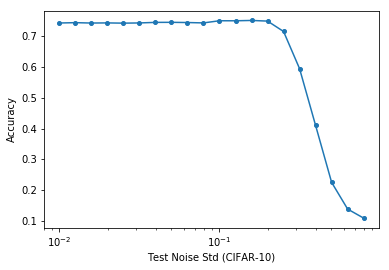

In [14]:
plt.plot(stds, acc, 'o-', markersize=4)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Test Noise Std (CIFAR-10)')
plt.ylabel('Accuracy')
plt.show()

---

In [9]:
train_std = [0, 0.01, 0.02, 0.05, 0.1, 0.2]

In [112]:
accs = []
stds = 10 ** np.arange(-2, 0, 0.1)

for i in range(6):
    
    model_name = 'cifar10_resnet_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    acc = []
    for std in stds:
        with torch.no_grad():
            rnd = torch.randn_like(x_test) * std
            x_rnd = torch.clamp(x_test + rnd, 0, 1)
            y_pred = classify(net, x_rnd)
            acc.append((y_pred.argmax(1) == y_test).sum().numpy() / y_test.size(0))
    accs.append(acc)

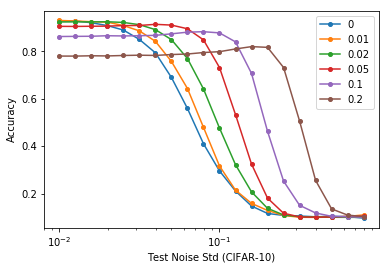

In [113]:
for i, acc in enumerate(accs):
    plt.plot(stds, acc, 'o-', label=train_std[i], markersize=4)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Test Noise Std (CIFAR-10)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [114]:
accs = []
stds = 10 ** np.arange(-2, 0, 0.1)

for i in range(6):
    
    model_name = 'cifar10_resnet_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    with torch.no_grad():
        y_pred = classify(net, x_test)
        correct_idx = np.where(y_pred.argmax(1) == y_test)[0]
    
        acc = []
        for std in stds:
            rnd = torch.randn_like(x_test[correct_idx]) * std
            x_rnd = torch.clamp(x_test[correct_idx] + rnd, 0, 1)
            y_pred = classify(net, x_rnd)
            acc.append((y_pred.argmax(1) == y_test[correct_idx]).sum().numpy() / len(correct_idx))
            
    accs.append(acc)

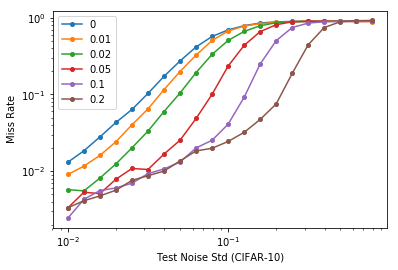

In [115]:
for i, acc in enumerate(accs):
    plt.plot(stds, 1 - np.array(acc), 'o-', label=train_std[i], markersize=4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Test Noise Std (CIFAR-10)')
plt.ylabel('Miss Rate')
plt.legend()
plt.show()

In [117]:
# Test Hypothesis (3)

accs = []
stds = 10 ** np.arange(-2, 0, 0.1)

for i in range(6):
    
    model_name = 'cifar10_resnet_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    with torch.no_grad():
        y_pred = classify(net, x_test)
        inc_idx = np.where(y_pred.argmax(1) != y_test)[0]
    
        acc = []
        for std in stds:
            rnd = torch.randn_like(x_test[inc_idx]) * std
            x_rnd = torch.clamp(x_test[inc_idx] + rnd, 0, 1)
            y_pred = classify(net, x_rnd)
            acc.append((y_pred.argmax(1) == y_test[inc_idx]).sum().numpy() / len(inc_idx))
            
    accs.append(acc)

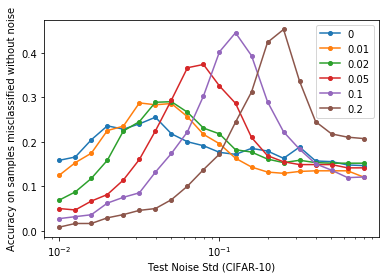

In [118]:
for i, acc in enumerate(accs):
    plt.plot(stds, np.array(acc), 'o-', label=train_std[i], markersize=4)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Test Noise Std (CIFAR-10)')
plt.ylabel('Accuracy on samples misclassified without noise')
plt.legend()
plt.show()

In [ ]:
y_pred = y_pred = classify(net, x_test[inc_idx] + rnd)

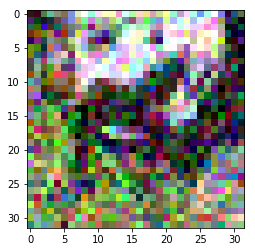

In [60]:
std = 0.2
rnd = torch.randn((3, 32, 32)) * std
plt.imshow(torch.clamp(x_test[20] + rnd, 0, 1).numpy().transpose(1, 2, 0))
plt.show()

---

Check the same effects on training set

In [18]:
accs = []
stds = 10 ** np.arange(-2, 0, 0.1)
num_test = 10000

for i in range(6):
    
    model_name = 'cifar10_resnet_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    acc = []
    for std in stds:
        with torch.no_grad():
            rnd = torch.randn_like(x_train[:num_test]) * std
            y_pred = y_pred = classify(net, x_train[:num_test] + rnd)
            acc.append((y_pred.argmax(1) == y_train[:num_test]).sum().numpy() / num_test)
    accs.append(acc)

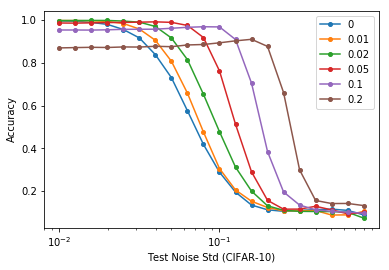

In [19]:
for i, acc in enumerate(accs):
    plt.plot(stds, acc, 'o-', label=train_std[i], markersize=4)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Test Noise Std (CIFAR-10)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Notice that the above plot looks exactly the same as the one with test set
# but the accuracy is just higher

In [20]:
accs = []
stds = 10 ** np.arange(-2, 0, 0.1)
num_test = 10000

for i in range(6):
    
    model_name = 'cifar10_resnet_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    with torch.no_grad():
        y_pred = classify(net, x_train[:num_test])
        correct_idx = np.where(y_pred.argmax(1) == y_train[:num_test])[0]
    
        acc = []
        for std in stds:
            rnd = torch.randn_like(x_train[correct_idx]) * std
            y_pred = y_pred = classify(net, x_train[correct_idx] + rnd)
            acc.append((y_pred.argmax(1) == y_train[correct_idx]).sum().numpy() / len(correct_idx))
            
    accs.append(acc)

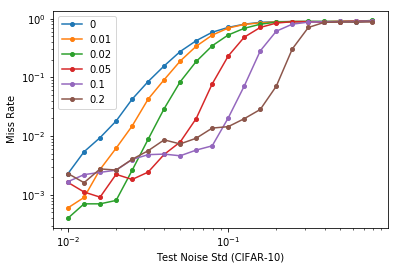

In [21]:
for i, acc in enumerate(accs):
    plt.plot(stds, 1 - np.array(acc), 'o-', label=train_std[i], markersize=4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Test Noise Std (CIFAR-10)')
plt.ylabel('Miss Rate')
plt.legend()
plt.show()

---

Diagonal interpolation

In [93]:
num_test = 100
num_rnd = 100
num_steps = 10
radius = math.sqrt(3072) * 0.2
step_size = radius / num_steps
y_pred = torch.zeros((num_test, num_rnd, num_steps))

for i in range(num_test):
    
    x = x_test[i]
    
    noise = torch.randn((num_rnd, 3, 32, 32)).view(num_rnd, -1)
    noise = F.normalize(noise, 2, 1).view(num_rnd, 3, 32, 32)
    
    for j in range(num_rnd):
        
        inter = noise[j] * step_size * torch.arange(1, num_steps + 1).view(
            10, 1, 1, 1).type(torch.FloatTensor)
        y_pred[i, j] = classify(net, x + inter).argmax(1)

In [118]:
(y_pred.type(torch.LongTensor) == y_test[:num_test].view(num_test, 1, 1)).sum(1).type(torch.FloatTensor).mean(0)

tensor([74.3000, 74.6000, 75.1500, 75.8400, 77.0100, 78.3300, 79.3700, 80.1000,
        80.4800, 79.4700])

In [119]:
num_test = 1000
num_rnd = 100
num_steps = 10
radius = math.sqrt(3072) * 0.2 * 1.2
step_size = radius / num_steps
y_pred = torch.zeros((num_test, num_rnd, num_steps))

for i in range(num_test):
    
    x = x_test[i]
    
    noise = torch.randn((num_rnd, 3, 32, 32)).view(num_rnd, -1)
    noise = F.normalize(noise, 2, 1).view(num_rnd, 3, 32, 32)
    
    for j in range(num_rnd):
        
        inter = noise[j] * step_size * torch.arange(1, num_steps + 1).view(
            10, 1, 1, 1).type(torch.FloatTensor)
        y_pred[i, j] = classify(net, x + inter).argmax(1)

In [142]:
mean_acc = (y_pred.type(torch.LongTensor) == y_test[:num_test].view(num_test, 1, 1)).sum(
    1).sum(0).type(torch.FloatTensor) / (num_test * num_rnd)

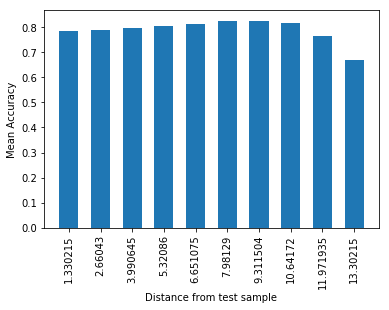

In [145]:
steps = step_size * torch.arange(1, num_steps + 1).type(torch.FloatTensor)
plt.bar(steps, mean_acc, tick_label=steps)
plt.xticks(rotation=90)
plt.xlabel('Distance from test sample')
plt.ylabel('Mean Accuracy')
plt.show()

In [147]:
# measure distance between classes

min_dist = torch.zeros(x_test.size(0))

for i in range(x_test.size(0)):
    
    dist = (x_test[i].unsqueeze(0) - x_test).view(x_test.size(0), -1).norm(2, 1)
    min_dist[i] = dist[y_test[i] != y_test].min()

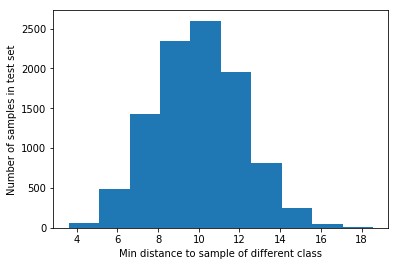

In [149]:
plt.hist(min_dist)
plt.xlabel('Min distance to sample of different class')
plt.ylabel('Number of samples in test set')
plt.show()

In [150]:
# average norm of Gaussian noise
math.sqrt(3072) * 0.2

11.085125168440815

In [154]:
np.percentile(min_dist, 1)

5.364959411621094

In [ ]:
# Check multiple noises per sample

In [26]:
accs = []
stds = 10 ** np.arange(-2, 0, 0.2)
num_test = 1000
num_rnd = 100
y_pred = torch.zeros((6, len(stds), num_test, num_rnd))

for i in range(6):
    
    model_name = 'cifar10_resnet_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    for s, std in enumerate(stds):
        with torch.no_grad():
            
            for j in range(num_test):
                x = x_test[j] + torch.randn((num_rnd, 3, 32, 32)) * std
                y_pred[i, s, j] = classify(net, x).argmax(1)

In [38]:
acc = np.zeros((6, len(stds), num_rnd))
for i in range(6):
    acc[i] = (y_pred[i] == y_test[:num_test].unsqueeze(1).type(torch.float32)).type(torch.float32).mean(1)

[None]

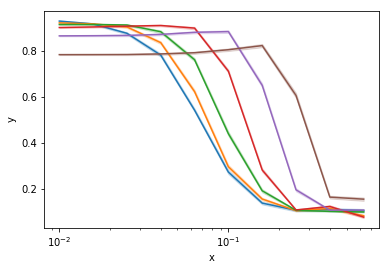

In [92]:
import seaborn as sns
import pandas as pd

for i in range(6):
    df = pd.DataFrame(dict(x=np.repeat(np.array(stds), num_rnd), y=acc[i].reshape(-1)))
    grid = sns.lineplot(x='x', y='y', ci='sd', data=df)

# grid.set(xscale="log", yscale="log")
grid.set(xscale="log")

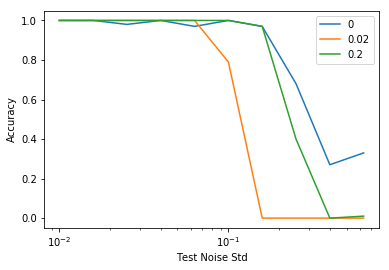

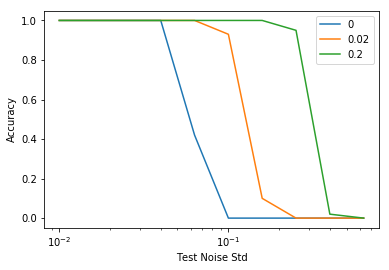

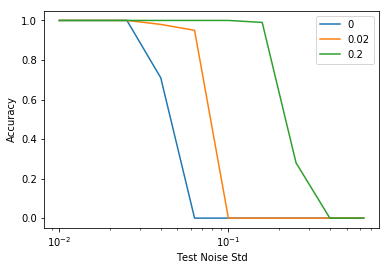

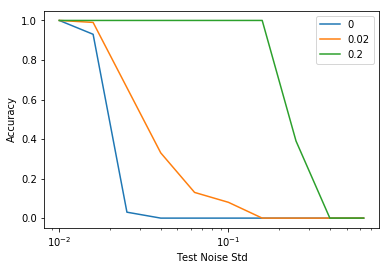

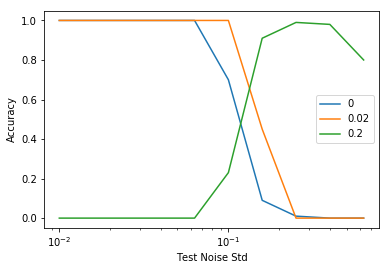

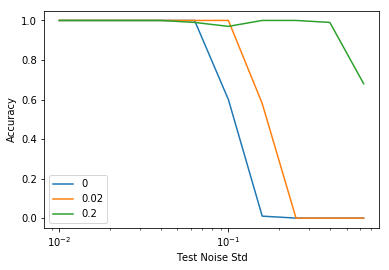

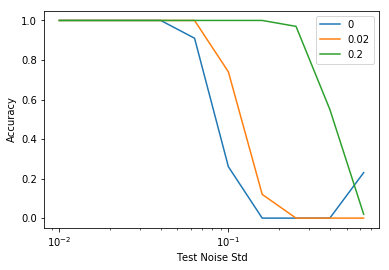

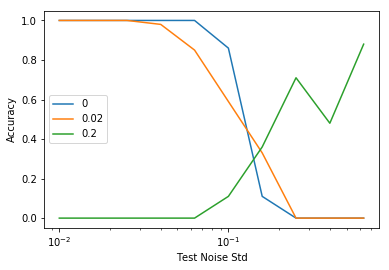

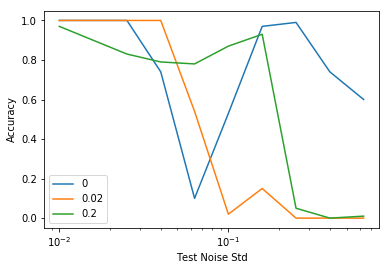

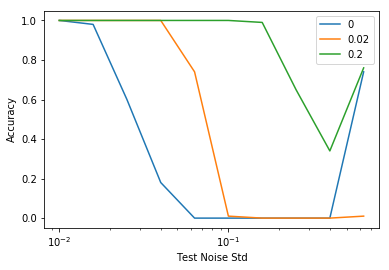

In [108]:
for idx in range(10):

    acc = np.zeros((6, len(stds)))
    for i in range(6):
        acc[i] = (y_pred[i, :, idx] == y_test[idx].type(torch.float32)).type(torch.float32).mean(1)
        
    for i in [0, 2, 5]:
        df = pd.DataFrame(dict(x=stds, y=acc[i]))
        grid = sns.lineplot(x='x', y='y', ci='sd', data=df, label=train_std[i])

    # grid.set(xscale="log", yscale="log")
    grid.set(xscale="log", 
             xlabel='Test Noise Std', 
             ylabel='Accuracy')
    plt.legend()
    plt.show()

In [109]:
accs = []
stds = 10 ** np.arange(-2, 0, 0.1)
num_test = 100
num_rnd = 1000
y_pred = torch.zeros((6, len(stds), num_test, num_rnd))

for i in range(6):
    
    model_name = 'cifar10_resnet_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    for s, std in enumerate(stds):
        with torch.no_grad():
            
            for j in range(num_test):
                x = x_test[j] + torch.randn((num_rnd, 3, 32, 32)) * std
                y_pred[i, s, j] = classify(net, x).argmax(1)

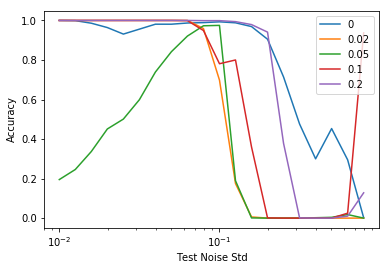

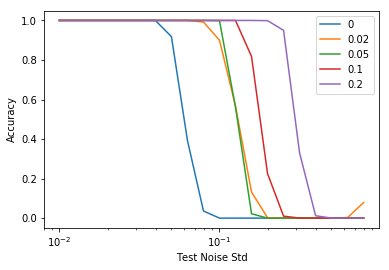

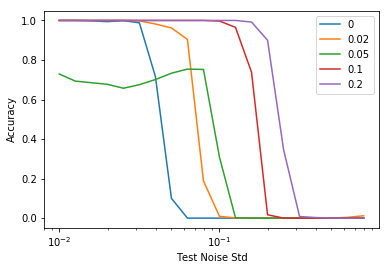

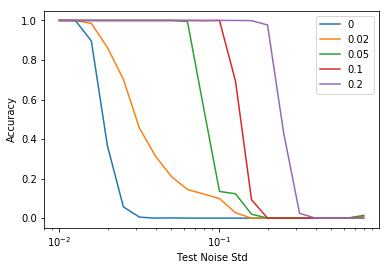

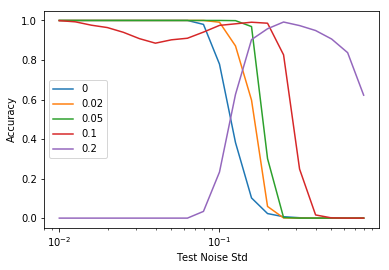

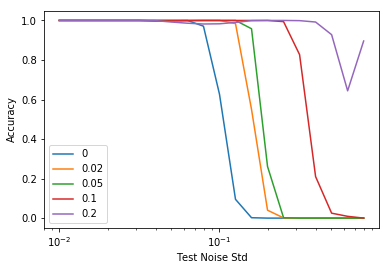

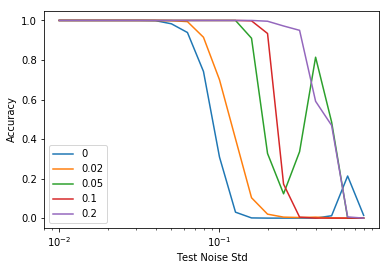

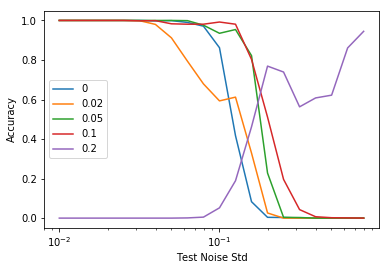

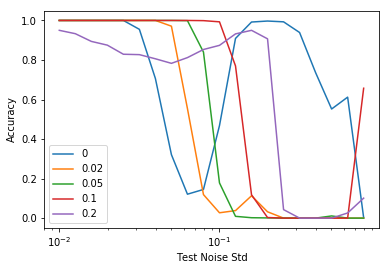

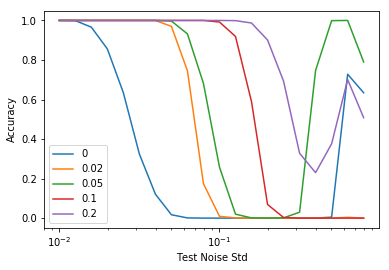

In [111]:
for idx in range(10):

    acc = np.zeros((6, len(stds)))
    for i in range(6):
        acc[i] = (y_pred[i, :, idx] == y_test[idx].type(torch.float32)).type(torch.float32).mean(1)
        
    for i in [0, 2, 3, 4, 5]:
        df = pd.DataFrame(dict(x=stds, y=acc[i]))
        grid = sns.lineplot(x='x', y='y', ci='sd', data=df, label=train_std[i])

    # grid.set(xscale="log", yscale="log")
    grid.set(xscale="log", 
             xlabel='Test Noise Std', 
             ylabel='Accuracy')
    plt.legend()
    plt.show()